# Audio generation example
#### following https://gist.github.com/naotokui/12df40fa0ea315de53391ddc3e9dc0b9



In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from pydub import AudioSegment

%matplotlib inline

track_path = 'source/raingurl.wav'

### if need to convert mp3 -> wav

In [2]:
if track_path.endswith("mp3"):
    track = AudioSegment.from_mp3(track_path)
    track_path = track_path.replace("mp3", "wav")
    track.export(track_path, format="wav")

### now get to work

In [3]:
sample_rate = 32000
y, _ = librosa.load(track_path, sr=sample_rate, mono=True, offset=68, duration=80)
print(y.shape)

y = y[530000:560000]

min_y = np.min(y)
max_y = np.max(y)

y = (y - min_y) / (max_y - min_y)
print(y.dtype, min_y, max_y)

Audio(y, rate=sample_rate)

(2560000,)
float32 -0.984327 1.03258


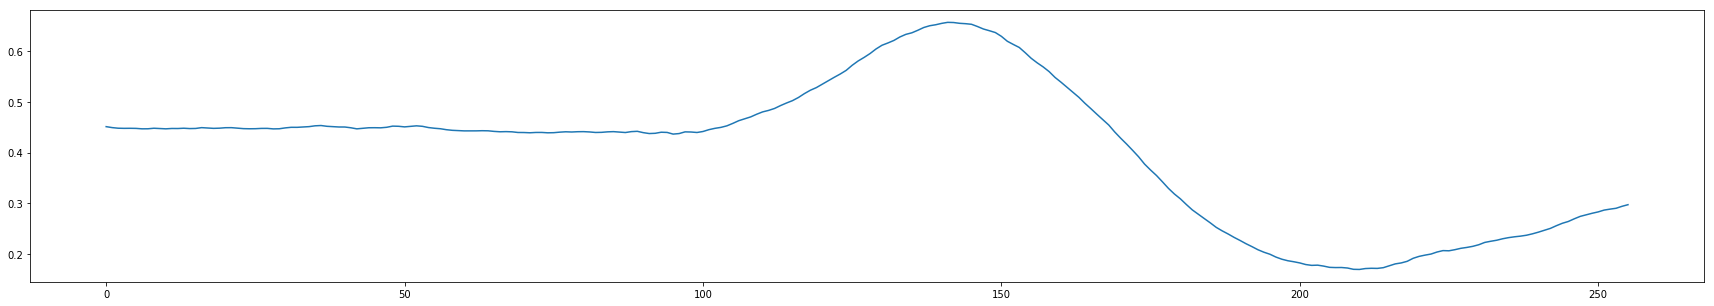

In [4]:
plt.figure(figsize=(30, 5))
plt.plot(y[20000:20256])
plt.show()

### build model

In [5]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # what is this for??

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.layers import Input
from keras.optimizers import RMSprop
import tensorflow as tf

window_size = 128
nb_output = 256 # resolution - 8-bit encoding
latent_dim = 128

inputs = Input(shape=(window_size, nb_output))
x = LSTM(latent_dim, return_sequences=True)(inputs)
x = Dropout(0.4)(x)
x = LSTM(latent_dim)(x)
x = Dropout(0.4)(x)
output = Dense(nb_output, activation='softmax')(x)
model = Model(inputs, output)
print(model.summary())

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 128)          197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
Total params: 361,728
Trainable params: 361,728
Non-trainable params: 0
_________________________________________________________________
None

In [6]:
from tqdm import tqdm

# estimate (0 - 255) based on 256 previous samples
step = 5
next_sample = []
samples = []

for j in tqdm(range(0, y.shape[0] - window_size, step)):
    seq = y[j: j + window_size + 1]
    seq_matrix = np.zeros((window_size, nb_output), dtype=bool)
    for i,s in enumerate(seq):
        sample_ = int(s * (nb_output - 1)) #0-255
        if i < window_size:
            seq_matrix[i, sample_] = True
        else:
            seq_vec = np.zeros(nb_output, dtype=bool)
            seq_vec[sample_] = True
            next_sample.append(seq_vec)
    samples.append(seq_matrix)
samples = np.array(samples, dtype=bool)
next_sample = np.array(next_sample, dtype=bool)
print(samples.shape, next_sample.shape)
    

100%|██████████| 5975/5975 [00:02<00:00, 2039.43it/s]


(5975, 128, 256) (5975, 256)


### prep and fit model

In [8]:
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
csv_logger = CSVLogger('training_audio.log')
escb = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
checkpoint = ModelCheckpoint('models/audio-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, period=2)

model.fit(samples, next_sample, shuffle=True, batch_size=256, verbose=1, validation_split=0.1, epochs=300, 
          callbacks=[csv_logger, checkpoint])

Train on 5377 samples, validate on 598 samples
Epoch 1/300
5377/5377 [==============================] - 30s 6ms/step - loss: 2.3106 - val_loss: 2.9148
Epoch 2/300
5377/5377 [==============================] - 30s 6ms/step - loss: 2.2748 - val_loss: 2.6214
Epoch 3/300
5377/5377 [==============================] - 30s 6ms/step - loss: 2.2148 - val_loss: 2.6407
Epoch 4/300
5377/5377 [==============================] - 30s 6ms/step - loss: 2.0745 - val_loss: 2.8610
Epoch 5/300
5377/5377 [==============================] - 30s 6ms/step - loss: 2.0134 - val_loss: 2.8012
Epoch 6/300
5377/5377 [==============================] - 30s 6ms/step - loss: 1.9787 - val_loss: 2.8047
Epoch 7/300
5377/5377 [==============================] - 30s 6ms/step - loss: 1.8798 - val_loss: 2.7589
Epoch 8/300
5377/5377 [==============================] - 30s 6ms/step - loss: 1.8442 - val_loss: 2.7163
Epoch 9/300
5377/5377 [==============================] - 30s 6ms/step - loss: 1.7931 - val_loss: 2.8269
Epoch 10/300
5377

Epoch 51/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.7750 - val_loss: 4.2702
Epoch 52/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.7173 - val_loss: 4.4282
Epoch 53/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.6940 - val_loss: 4.5170
Epoch 54/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.7597 - val_loss: 4.4106
Epoch 55/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.6828 - val_loss: 4.5113
Epoch 56/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.7354 - val_loss: 4.4680
Epoch 57/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.6634 - val_loss: 4.5671
Epoch 58/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.6894 - val_loss: 4.7678
Epoch 59/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.6807 - val_loss: 4.6201
Epoch 60/300
5377/5377 [==============================]

Epoch 101/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.4668 - val_loss: 5.5285
Epoch 102/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.4030 - val_loss: 5.7410
Epoch 103/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.4109 - val_loss: 5.8018
Epoch 104/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.4189 - val_loss: 5.8213
Epoch 105/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.4495 - val_loss: 5.6729
Epoch 106/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.4662 - val_loss: 5.8215
Epoch 107/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.4163 - val_loss: 5.8613
Epoch 108/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.4197 - val_loss: 5.8474
Epoch 109/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.4532 - val_loss: 5.8857
Epoch 110/300
5377/5377 [=====================

5377/5377 [==============================] - 30s 6ms/step - loss: 0.3702 - val_loss: 6.1060
Epoch 151/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.3234 - val_loss: 6.2760
Epoch 152/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.3456 - val_loss: 6.1854
Epoch 153/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.3336 - val_loss: 6.2211
Epoch 154/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.3624 - val_loss: 6.2520
Epoch 155/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.3350 - val_loss: 6.3204
Epoch 156/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.3276 - val_loss: 6.3231
Epoch 157/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.2877 - val_loss: 6.4262
Epoch 158/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.3279 - val_loss: 6.4413
Epoch 159/300
5377/5377 [==============================] - 3

Epoch 199/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.2951 - val_loss: 6.7452
Epoch 200/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.3410 - val_loss: 6.8344
Epoch 201/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.4929 - val_loss: 6.8694
Epoch 202/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.3619 - val_loss: 6.9719
Epoch 203/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.2600 - val_loss: 6.9990
Epoch 204/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.2268 - val_loss: 6.8988
Epoch 205/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.2398 - val_loss: 6.9989
Epoch 206/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.2197 - val_loss: 6.9207
Epoch 207/300
5377/5377 [==============================] - 30s 6ms/step - loss: 0.2042 - val_loss: 7.0480
Epoch 208/300
5377/5377 [=====================

5377/5377 [==============================] - 30s 6ms/step - loss: 0.3985 - val_loss: 7.0340
Epoch 249/300
5377/5377 [==============================] - 30s 6ms/step - loss: 1.4489 - val_loss: 7.4084
Epoch 250/300
5377/5377 [==============================] - 30s 6ms/step - loss: 2.1277 - val_loss: 7.2168
Epoch 251/300
5377/5377 [==============================] - 30s 6ms/step - loss: 2.4672 - val_loss: 7.2157
Epoch 252/300
5377/5377 [==============================] - 30s 6ms/step - loss: 2.3295 - val_loss: 6.9821
Epoch 253/300
5377/5377 [==============================] - 30s 6ms/step - loss: 1.9499 - val_loss: 6.7822
Epoch 254/300
5377/5377 [==============================] - 30s 6ms/step - loss: 1.9083 - val_loss: 7.1355
Epoch 255/300
5377/5377 [==============================] - 30s 6ms/step - loss: 6.7076 - val_loss: 6.6061
Epoch 256/300
5377/5377 [==============================] - 30s 6ms/step - loss: 7.2218 - val_loss: 5.7370
Epoch 257/300
5377/5377 [==============================] - 3

Epoch 297/300
5377/5377 [==============================] - 30s 6ms/step - loss: 4.3512 - val_loss: 4.9111
Epoch 298/300
5377/5377 [==============================] - 30s 6ms/step - loss: 4.3583 - val_loss: 4.8219
Epoch 299/300
5377/5377 [==============================] - 30s 6ms/step - loss: 4.2083 - val_loss: 4.6581
Epoch 300/300
5377/5377 [==============================] - 30s 6ms/step - loss: 4.2217 - val_loss: 4.5196


training History


Text(0.5,1,'validation loss')

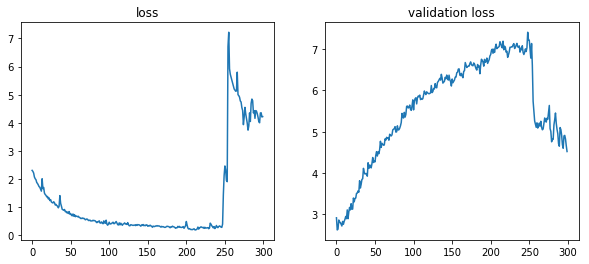

In [9]:
print("training History")
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(model.history.history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(model.history.history['val_loss'])
ax2.set_title('validation loss')

100%|██████████| 50000/50000 [24:42<00:00, 33.72it/s]


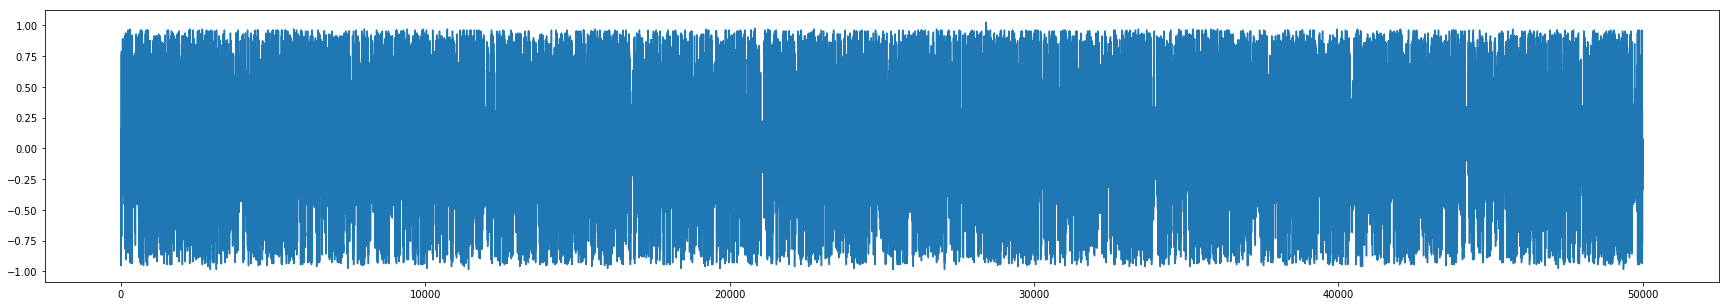

 34%|███▍      | 17019/50000 [08:28<16:26, 33.45it/s]

KeyboardInterrupt: 

 34%|███▍      | 17019/50000 [08:40<16:48, 32.70it/s]

In [10]:
from IPython.display import display

def sample(preds, temperature=1.0, min_value=0, max_value=1):
    #helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    v = np.argmax(probas)/float(probas.shape[1])
    return v * (max_value - min_value) + min_value

for start in range(50000, 300000, 100000):
    seq = y[start: window_size]
    seq_matrix = np.zeros((window_size, nb_output), dtype=bool)
    for i,s in enumerate(seq):
        sample_ = int(s * (nb_output - 1)) # 0-255
        seq_matrix[i, sample_] = True
    
    for i in tqdm(range(50000)):
        z = model.predict(seq_matrix.reshape((1, window_size, nb_output)))
        s = sample(z[0], 1.0)
        seq = np.append(seq, s)
        
        sample_ = int(s * (nb_output - 1))
        seq_vec = np.zeros(nb_output, dtype=bool)
        seq_vec [sample_] = True
        
        seq_matrix = np.vstack((seq_matrix, seq_vec))
        seq_matrix = seq_matrix[1:]
        
    # scale back
    seq = seq * (max_y - min_y) + min_y
    
    # plot
    plt.figure(figsize=(30,5))
    plt.plot(seq.transpose())
    plt.show()
    
    display(Audio(seq, rate=sample_rate))

In [ ]:
#scale back does this bit do anything?
seq = seq * (max_y - min_y) + min_y

# plot
fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(2, 1, 1)
plt.plot(seq.transpose())

ax2 = fig.add_subplot(2, 1, 2)
plt.plot(seq[:30000].transpose())
plt.show()

display(Audio(seq, rate=sample_rate))